In [1]:
from research.analysis import nlp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
docs, labels = nlp.load_documents(n=1000)

In [3]:
entity_map = nlp.extract_entity_id_map(docs, extractor=nlp._text_to_tokens)

Entity count: 48580


(array([ 2023., 13169., 16914.,  9272.,  3718.,  1650.,   812.,   505.,
          319.,   198.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 10 Patch objects>)

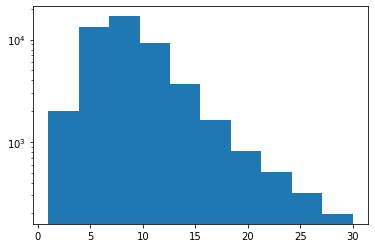

In [4]:
import numpy as np
entity_lengths = [len(e) for e in entity_map.keys()]
print("Entity count: {}".format(len(entity_lengths)))
plt.hist(entity_lengths, log=True)

In [5]:
import random
random.choices(list(entity_map.keys()), k=20)

['briah',
 'altadena',
 'adsterms',
 'archaeologies',
 'shipwreck',
 'ususmntthe',
 'opening',
 'unite',
 'candidates',
 'allysha',
 'akin',
 'inskip',
 'rockaways',
 'trinidad',
 'clapping',
 'undulating',
 'dismantling',
 'sox',
 'tactics',
 'schoolcustomizeokc']

In [6]:
bag = nlp.bag_of_entities(docs, entity_map)

In [7]:
tfidf = nlp.tfidf(bag)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, labels, test_size=0.5, random_state=40)

In [9]:
len(y_test)

500

In [10]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='BLM')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 10})

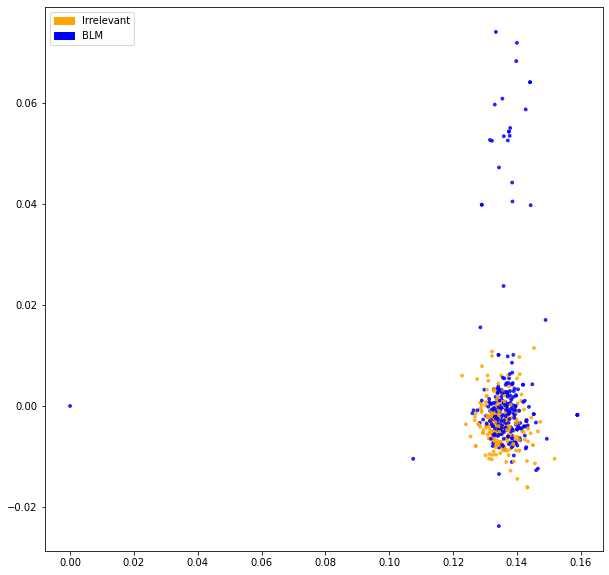

In [11]:
fig = plt.figure(figsize=(10,10))          
plot_LSA(X_train, y_train)
plt.show()

In [18]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1, class_weight='balanced', solver='newton-cg', random_state=41)
clf.fit(X_train, y_train)

y_predicted_counts = clf.predict(X_train)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.506, precision = 0.506, recall = 0.506, f1 = 0.506


In [20]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=8)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    return plt

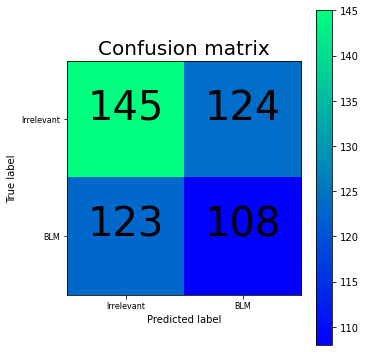

[[145 124]
 [123 108]]


In [21]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(5,5))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','BLM'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)